In [5]:
import pyemu
import flopy as fp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

## Dans ce notebook se passe l'inversion à proprement parler

On va d'abord loader les fichiers du dossier "master_glm" dans lequel a été calculée la jacobienne juste avant et voir un peu le recap des paramètres

In [6]:
t_d ="master_glm"
case="pest_test"
pst = pyemu.Pst(os.path.join(t_d,"{}.pst".format(case)))
pst.write_par_summary_table(filename="none")

,type,transform,count,initial value,upper bound,lower bound,standard deviation
kp_inst:0,kp_inst:0,log,64,0,1,-1,0.5


On va ensuite setup différentes variables propres à PEST++ qui permettent de contrôler pas mal de choses comme la gestion des super paramètres, combien de draws faire durant l'analyse d'incertitude, où se situe la matrice de covariance, la jacobienne, etc.

In [7]:
pst.control_data.noptmax = 9 # nombre max d'itérations (devrait être grand mais pour aller plus vite environ 5-7)
pst.pestpp_options["n_iter_base"] = -1 # nombre d'itérations des paramètres de bases (-1 demande à PEST ++ de se comporter comme PEST)
pst.pestpp_options["n_iter_super"] = 4 # (nombre d'itérations dans la détermination des super paramètres)
pst.pestpp_options["glm_num_reals"] = 50 # how many draws
pst.pestpp_options["parcov"] = "{}.prior.cov".format(case) # nom de la matrice de covariance
pst.pestpp_options["base_jacobian"] = "{}.jcb".format(case) # nom de la jacobienne pour directement commencer l'inversion
pst.write(os.path.join(t_d,"{}.pst".format(case)))

noptmax:9, npar_adj:64, nnz_obs:196


# AND RUN 

In [8]:
m_d = "master_glm_run"
pyemu.os_utils.start_workers(t_d,"../pestpp-glm","{}.pst".format(case),num_workers=10,worker_root=".",
                           master_dir=m_d)

## Checkons les résultats

[<Figure size 576x756 with 0 Axes>, <Figure size 576x756 with 8 Axes>]

<Figure size 576x756 with 0 Axes>

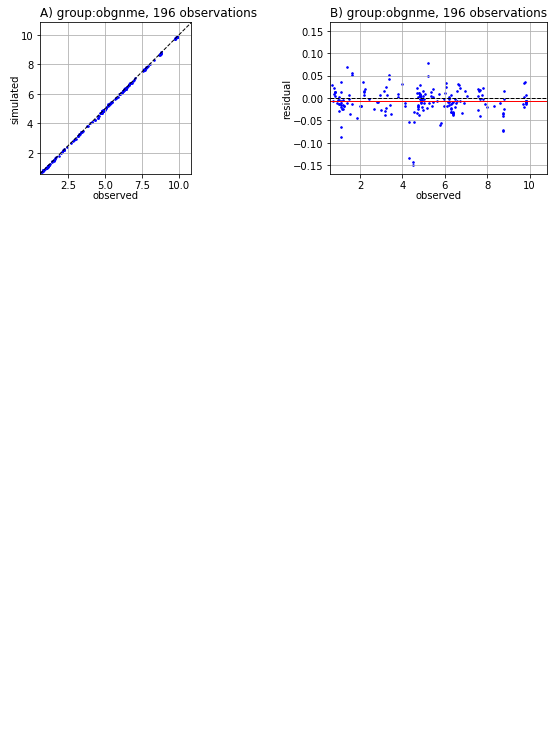

In [17]:
pst_a = pyemu.Pst(os.path.join(m_d,"{}.pst".format(case)))
pst_a.plot(kind='1to1')

### Quelques histogrammes pour voir la distribution des phi durant l'analyse d'incertitude et la variations des paramètres

C:\Users\schorppl\AppData\Local\Continuum\anaconda3\lib\site-packages\pyemu\en.py:365: UserWarning: Ensemble.from_dataframe() is deprecated and has been replaced with the standard constructor, which takesthe same arguments
  warnings.warn("Ensemble.from_dataframe() is deprecated and has been "


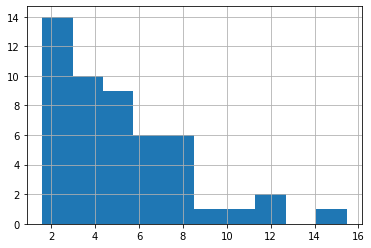

In [18]:
df = df=pd.read_csv(os.path.join(m_d,"{}.post.obsen.csv".format(case)),index_col=0)
oe = pyemu.ObservationEnsemble.from_dataframe(pst=pst,df=df)
ax = oe.phi_vector.hist()

In [19]:
dfp = df=pd.read_csv(os.path.join(m_d,"{}.par.usum.csv".format(case)),index_col=0)
10**dfp["post_mean"]

name
KP_INST:0_I:6_J:6      0.100000
KP_INST:0_I:6_J:18     0.100000
KP_INST:0_I:6_J:30     0.130012
KP_INST:0_I:6_J:42     1.163985
KP_INST:0_I:6_J:54     3.118602
                         ...   
KP_INST:0_I:90_J:42    0.695770
KP_INST:0_I:90_J:54    0.106165
KP_INST:0_I:90_J:66    0.448440
KP_INST:0_I:90_J:78    2.575420
KP_INST:0_I:90_J:90    0.907963
Name: post_mean, Length: 64, dtype: float64

(array([40.,  6.,  2.,  3.,  0.,  1.,  2.,  2.,  1.,  1.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,
         0.,  0.,  0.,  4.]),
 array([ 0.1 ,  0.43,  0.76,  1.09,  1.42,  1.75,  2.08,  2.41,  2.74,
         3.07,  3.4 ,  3.73,  4.06,  4.39,  4.72,  5.05,  5.38,  5.71,
         6.04,  6.37,  6.7 ,  7.03,  7.36,  7.69,  8.02,  8.35,  8.68,
         9.01,  9.34,  9.67, 10.  ]),
 <a list of 30 Patch objects>)

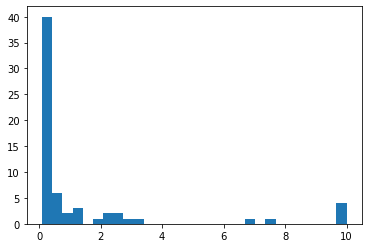

In [20]:
plt.hist(10**dfp["post_mean"],bins=30)

### Résultats de l'inversion

Afin d'obtenir la carte de k après inversion il est possible de relancer un run du modèle avec les meilleures valeurs de paramètres et un noptmax de 0 (un seul run)

In [21]:
pst.parameter_data.parval1 = 10**dfp["post_mean"].values
pst.control_data.noptmax = 0 # one run with optimal parameters

pst.write(os.path.join(t_d,"{}.pst".format(case)))

pyemu.os_utils.run("..\pestpp-glm.exe {}".format(case),cwd=t_d)

noptmax:0, npar_adj:64, nnz_obs:196


Text(0.5, 1.0, 'k after inversion')

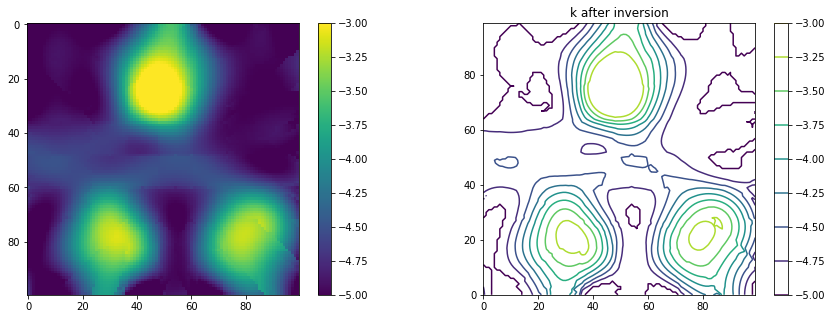

In [22]:
fig,ax = plt.subplots(1,2,figsize=(15,5))

# inversion
g= ax[0].imshow(np.log10(np.loadtxt(os.path.join(t_d,"k.txt"))))
plt.colorbar(g,ax=ax[0])
plt.title("k after inversion")

a=ax[1].contour(np.flipud(np.log10(np.loadtxt(os.path.join(t_d,"k.txt")))))
ax[1].set_aspect("equal")
plt.colorbar(a,ax=ax[1])
plt.title("k after inversion")

### Réalité

Fichier dans le "workspace"

Text(0.5, 1.0, 'k after inversion')

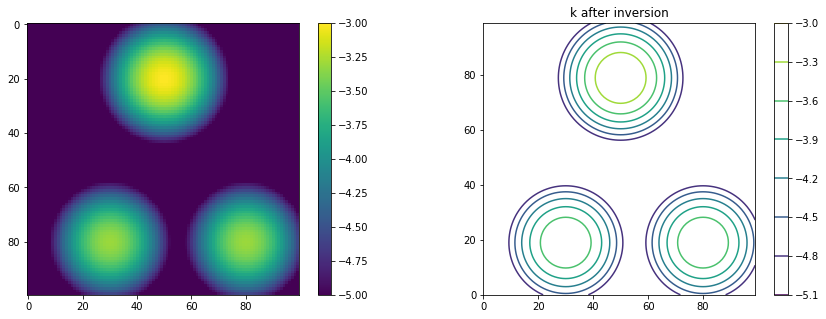

In [23]:
fig,ax = plt.subplots(1,2,figsize=(15,5))

# inversion
g= ax[0].imshow(np.log10(np.loadtxt(os.path.join("workspace","k.txt"))))
plt.colorbar(g,ax=ax[0])
plt.title("k after inversion")

a=ax[1].contour(np.flipud(np.log10(np.loadtxt(os.path.join("workspace","k.txt")))))
ax[1].set_aspect("equal")
plt.colorbar(a,ax=ax[1])
plt.title("k after inversion")

### evolution de PHI

0.18217679153550995 {'obgnme': 0.18217679153550995} {'obgnme': 1.0}


[None,
 None,

<Figure size 576x756 with 0 Axes>

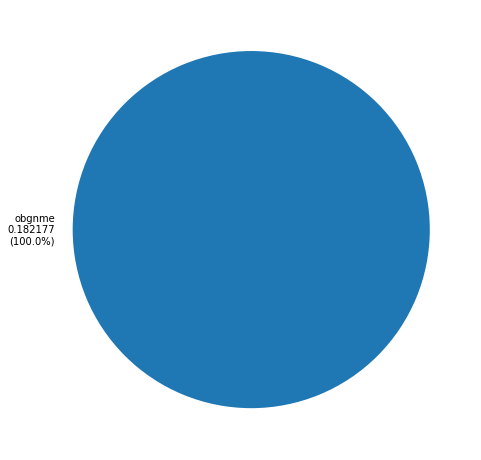

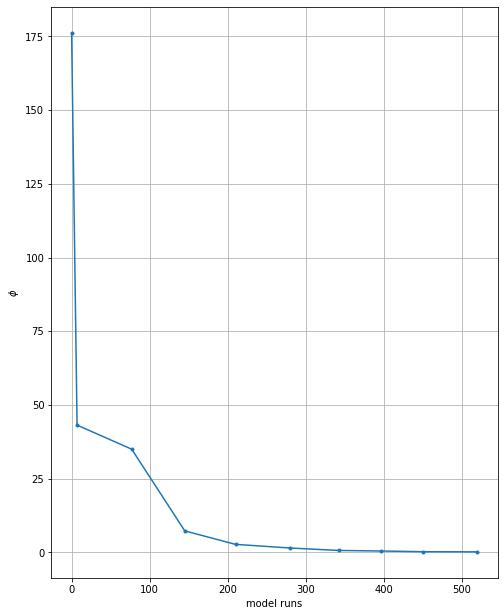

In [24]:
pst_a.plot()